In [1]:
!pip install pytorch_lightning tensorboard

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import pytorch_lightning as pl
from pathlib import Path
import seaborn as sns
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
DATA_DIR = Path('/kaggle/input/solvro-rekrutacja-zimowa-ml-2023')
WRITING_DIR = Path('/kaggle/working')
SUBDATA_DIR = WRITING_DIR / 'subdata'

SUBMISSIONS_DIR = WRITING_DIR

os.makedirs(SUBDATA_DIR, exist_ok=True)
os.makedirs(SUBMISSIONS_DIR, exist_ok=True)

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/sample_submission.csv
/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/y_train.npy
/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/y_val.npy
/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/X_test.npy
/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/X_val.npy
/kaggle/input/solvro-rekrutacja-zimowa-ml-2023/X_train.npy


In [3]:
import numpy as np

CLASS_LABELS = np.array([chr(label + ord('A')) for label in range(26)])
IMG_SIZE = (28, 28)

In [4]:
from pathlib import Path
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def id_2_label(idx):
    return CLASS_LABELS[idx]


def label_2_id(label):
    return ord(label) - ord('A')


def oneh_2_label(one_hot_id):
    return CLASS_LABELS[one_hot_id.argmax(axis=-1)]


def label_2_1hot(label):
    arr = np.zeros(len(CLASS_LABELS))
    arr[label_2_id(label)] = 1
    return arr


def get_classes_count(y_true):
    class_labels = oneh_2_label(y_true)
    return pd.Series(class_labels).value_counts()


def split_save(X, y, test_size=0.25, stratify=None, writing_dir=Path("../data/input_data")):

    X_subval, X_subtest, y_subval, y_subtest = train_test_split(X, y, stratify=stratify,
                                              test_size=test_size, random_state=42)

    np.save(writing_dir / 'X_subval.npy', X_subval)
    np.save(writing_dir / 'y_subval.npy', y_subval)
    np.save(writing_dir / 'X_subtest.npy', X_subtest)
    np.save(writing_dir / 'y_subtest.npy', y_subtest)

In [5]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support

def min_f1_score(y_true, y_pred):
    f1_score_by_class = f1_score(y_true, y_pred, average=None)
    return f1_score_by_class.min()


def get_classification_report(y_true, y_pred):
    precision, recall, f1score, support = precision_recall_fscore_support(y_true, y_pred)
    clf_report_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1score, 'support': support},
                                 index=id_2_label(np.arange(len(CLASS_LABELS))))

    return clf_report_df

In [6]:
import torch.nn as nn


class CustomConv2d(nn.Module):

    def __init__(self, n_channels_in, n_channels_out, kernel_size, pad,
                 use_pooling=False, stride=1, drop=None, batch_norm=True,
                 activ=nn.ReLU):
        super(CustomConv2d, self).__init__()
        # We can use here separable convolutions
        layers = [nn.Conv2d(n_channels_in, n_channels_out, kernel_size, stride=stride,
                            padding=pad)]
        if use_pooling:
            layers.append(nn.MaxPool2d(kernel_size=kernel_size))
        if activ:
            layers.append(activ())
        if batch_norm:
            layers.append(nn.BatchNorm2d(n_channels_out))
        if drop:
            layers.append(nn.Dropout2d(drop))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class Flatten(nn.Module):

    def __init__(self, keep_batch_dim=True):
        super(Flatten, self).__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            # -1 means that it will figure out the size
            return x.view(x.shape[0], -1)
        return x.view(-1)


In [7]:
class BaseCNN(pl.LightningModule):

    def __init__(self, class_weights=None, act_fn=F.relu):
        super().__init__()

        self.act_fn = act_fn
        self.class_weights = class_weights

    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = F.cross_entropy(predictions, y, weight=self.class_weights)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = F.cross_entropy(predictions, y)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'val_loss': loss}


    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        predictions = self(x)
        predicted_labels = torch.argmax(predictions, axis=-1)
        return predicted_labels

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [8]:
from typing import List

class DeepCNN(BaseCNN):

    def __init__(self, convolutional_layers: List[CustomConv2d],
                 linear_layers: List[nn.Linear], **kwargs):
        super(DeepCNN, self).__init__(**kwargs)

        self.conv_layers = nn.Sequential(*convolutional_layers)
        self.flatten = Flatten()
        self.lin_layers = nn.ModuleList(linear_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        # x = self.dropout(x)
        for lin_layer in self.lin_layers[:-1]:
          x = self.act_fn(lin_layer(x))
        x = self.lin_layers[-1](x)
        return x

In [9]:
def compute_output_size(input_size, kernel_size, padding=0,
                        stride=1):
    return (input_size - kernel_size + 2 * padding) / stride + 1

compute_output_size(28, 3, padding=1)

28.0

In [10]:
28 * 28 * 64

50176

In [11]:
X_val = np.load(DATA_DIR / 'X_val.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
split_save(X_val, y_val, stratify=y_val, writing_dir=SUBDATA_DIR)

y_train = np.load(DATA_DIR / 'y_train.npy')

y_true = np.load(SUBDATA_DIR / 'y_subtest.npy')
y_true_labels = y_true.argmax(axis=-1)

subtest_labels = np.load(SUBDATA_DIR / 'y_subtest.npy').argmax(axis=-1)

In [12]:
X_train = np.load(DATA_DIR / 'X_train.npy')

X_mean = X_train.mean()
X_std = X_train.std()

def normalize(X):
    return (X - X_mean) / X_std

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomPerspective, RandomRotation, RandomResizedCrop
import torch

image_transform = transforms.Compose(
    [RandomHorizontalFlip(p=0.25),
    RandomVerticalFlip(p=0.25),
    RandomResizedCrop((28, 28), scale=(0.8,1.0), ratio=(0.9,1.1), antialias=True),
    RandomPerspective(distortion_scale=0.5, p=0.25, fill=0),
    RandomRotation(degrees=45)]
)

class ImgTransform:

    def __init__(self, img_transform, color_channel=False):
        self.img_transform = img_transform
        self.color_channel = color_channel

    def __call__(self, sample):
        x, y = sample
        x = x.reshape(1, *IMG_SIZE) # add color channel
        if not self.color_channel:
            x = self.img_transform(x).reshape(*IMG_SIZE) # remove color channel
        return x, y


def visualize_img_transform(sample_img, label, transform):
    img_tensor = torch.from_numpy(sample_img.reshape(1, *IMG_SIZE))
    plt.title(label)
    plt.imshow(transform(img_tensor).reshape(*IMG_SIZE), cmap='Greys')

class Reshape(object):

    def __init__(self, shape=(-1, )):
        self.shape = shape

    def __call__(self, sample):
        x, y = sample
        return x.reshape(self.shape), y

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HandwritingsDataset(Dataset):

    def __init__(self, X_file_path, y_file_path=None,
                 sample_transform=None, data_transform=None):
        self.X_file_path = X_file_path
        self.y_file_path = y_file_path
        self.sample_transform = sample_transform

        self.X_data = np.load(X_file_path)

        y_data = np.load(y_file_path) if self.y_file_path else np.ones((len(self.X_data), 1))

        if data_transform:
            self.X_data = data_transform(self.X_data)

        self.y_labels = y_data.argmax(axis=-1)
        self.X_data = torch.from_numpy(self.X_data).to(torch.float32)

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        # Here we could load this lazily
        if self.sample_transform:
            return self.sample_transform([self.X_data[index], self.y_labels[index]])
        return self.X_data[index], self.y_labels[index]


class HandwritingsBalancedDataset(HandwritingsDataset):

    def __init__(self, sampling_algorithm, **kwargs):
        super().__init__(**kwargs)
        self.sampling_algorithm = sampling_algorithm
        self.transform_X_y()

    def transform_X_y(self):

        # Data for the resampler should be in format (n_samples, n_features)
        X = self.X_data.reshape(self.X_data.shape[0], -1)
        X, self.y_labels = self.sampling_algorithm.fit_resample(X, self.y_labels)
        self.X_data = X.reshape(-1, *IMG_SIZE)
        # Back to torch tensors
        self.X_data = torch.from_numpy(self.X_data).to(torch.float32)

In [16]:
batch_size = 32
max_epochs = 30
n_classes=len(CLASS_LABELS)

image_transform = ImgTransform(image_transform, color_channel=True)
reshape_transform = Reshape(shape=(1, *IMG_SIZE))

train_dataset = HandwritingsDataset(X_file_path=DATA_DIR / 'X_train.npy', y_file_path=DATA_DIR / 'y_train.npy',
                                            data_transform=normalize, sample_transform=image_transform)

train_loader = DataLoader(train_dataset, num_workers=4,
                         batch_size=batch_size, shuffle=True)


val_dataset = HandwritingsDataset(SUBDATA_DIR / 'X_subval.npy', SUBDATA_DIR / 'y_subval.npy',
                                             data_transform=normalize, sample_transform=reshape_transform)

val_loader = DataLoader(val_dataset, num_workers=4,
                                batch_size=batch_size, shuffle=False)

test_dataset = HandwritingsDataset(SUBDATA_DIR / 'X_subtest.npy', SUBDATA_DIR / 'y_subtest.npy',
                                             data_transform=normalize, sample_transform=reshape_transform)

test_loader = DataLoader(test_dataset, num_workers=4,
                                batch_size=batch_size, shuffle=False)

In [17]:
y_train = np.load(DATA_DIR / 'y_train.npy')
train_class_count = get_classes_count(y_train)
train_class_prob = train_class_count / train_class_count.sum()

def print_summary(report, f1_score_column):
    mean_f1_baseline = report[f1_score_column].mean()
    print(f"Mean f1 score [{f1_score_column}] = {mean_f1_baseline:.3f}")

    mean_train_prob = report['train_class_prob'].mean()
    print(f"Mean train class prob = {mean_train_prob:.3f}")

    f1_baseline_below_mean = report[report[f1_score_column] < mean_f1_baseline]
    class_prob_below_mean = report[report['train_class_prob'] < mean_train_prob]

    print("Classes with f1 score BELOW mean\n", f1_baseline_below_mean[[f1_score_column, 'train_class_prob']])
    print("Classes with probability BELOW mean\n", class_prob_below_mean[[f1_score_column, 'train_class_prob']])

    min_labels_below_mean = set(f1_baseline_below_mean.index) & set(class_prob_below_mean.index)

    print(min_labels_below_mean)
    print("What percentage of minority classes have scores below mean", f"{(len(min_labels_below_mean) / len(set(class_prob_below_mean.index))):.3f}")

    class_prob_above_mean = report[report['train_class_prob'] >= mean_train_prob]

    maj_labels_above_mean = set(f1_baseline_below_mean.index) & set(class_prob_above_mean.index)

    print(maj_labels_above_mean)
    print("What percentage of majority classes have scores below mean", f"{(len(maj_labels_above_mean) / len(set(class_prob_above_mean.index))):.3f}")


In [18]:
def plot_distributions(report, *f1_score_columns):
    plt.figure(figsize=(7, 7))
    sorted_class_labels = report.sort_index().index
    sns.barplot(data=report[['train_class_prob', *f1_score_columns]].reset_index().melt(value_vars=['train_class_prob', *f1_score_columns], id_vars=['index']), y='value',
               x='index', order=sorted_class_labels, hue='variable')
    plt.ylabel('Value')
    plt.xlabel('Letter')
    _ = plt.title('Distribution of class prob and f1')

def plot_f1_vs_class_prob(report, *f1_score_columns):
    plt.figure(figsize=(7, 7))
    sns.relplot(report[['train_class_prob', *f1_score_columns]].melt(value_vars=f1_score_columns, id_vars=['train_class_prob']), x='train_class_prob',
               y='value', hue='variable')
    plt.xlabel('Class probability')
    plt.ylabel('F1 score')
    _ = plt.title('Distribution of f1 vs class prob')

In [19]:
def save_submission(model, filename, sample_transform=None):

    eval_test_dataset = HandwritingsDataset(DATA_DIR / 'X_test.npy',
                                      data_transform=normalize, sample_transform=sample_transform)

    eval_test_loader = DataLoader(eval_test_dataset, num_workers=4,
                                    batch_size=batch_size, shuffle=False)

    trainer = pl.Trainer()
    eval_predictions =  torch.cat(trainer.predict(model, eval_test_loader)).numpy()

    predictions_df = pd.DataFrame(eval_predictions).reset_index()
    predictions_df.to_csv(SUBMISSIONS_DIR / filename, header=['index', 'class'], index=False)


### Approach 1

In [81]:
batch_size = 32
max_epochs = 30
n_classes=len(CLASS_LABELS)

conv_layers = [CustomConv2d(1, 32, 3, pad=1), CustomConv2d(32, 64, 3, pad=1),
               CustomConv2d(64, 128, 3, pad=1)]

n_conv_output = 28 * 28 * 128

linear_layers = [nn.Linear(n_conv_output, 1024), nn.Linear(1024, 512), nn.Linear(512, n_classes)]

cnn_checkpoint_dir = WRITING_DIR / 'cnn_3_conv_3_lin'

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=cnn_checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}',
                                      monitor='val_loss')

early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

cnn = DeepCNN(conv_layers, linear_layers)

trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=cnn_checkpoint_dir, callbacks=[checkpoint_callback, early_stopping],
                     fast_dev_run=True)
trainer.fit(cnn, train_loader, val_loader)

# cnn.save(cnn_checkpoint_dir / f'cnn_deep_3_conv_3_lin-{datetime.today().strftime("%d-%m-%Y %H:%M")}')

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /kaggle/working/cnn_3_conv_3_lin/best_results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
%reload_ext tensorboard

%tensorboard --logdir="drive/My Drive/zadanie-rekrutacyjne-solvro/working/cnn_3_conv_3_lin/lightning_logs" --port=6006

In [82]:
os.listdir(cnn_checkpoint_dir / 'best_results')

['epoch=2-val_loss=0.11-train_loss=0.08.ckpt']

In [83]:
cnn_checkpoint_dir = WRITING_DIR / 'cnn_3_conv_3_lin'
cnn = DeepCNN.load_from_checkpoint(cnn_checkpoint_dir / 'best_results/epoch=2-val_loss=0.11-train_loss=0.08.ckpt', convolutional_layers=conv_layers,
                                   linear_layers=linear_layers)
trainer = pl.Trainer()
predictions = trainer.predict(cnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       320
           1       0.99      0.97      0.98       194
           2       0.98      0.98      0.98       505
           3       0.84      0.93      0.88       228
           4       0.97      0.95      0.96       247
           5       0.97      0.98      0.98       459
           6       0.92      0.98      0.95       126
           7       0.96      0.98      0.97       158
           8       0.99      0.98      0.98       597
           9       0.96      0.97      0.96       188
          10       0.96      0.95      0.96       123
          11       0.96      0.95      0.96       254
          12       0.99      0.98      0.99       450
          13       0.99      0.98      0.98       412
          14       0.98      0.97      0.98      1249
          15       0.97      0.99      0.98       417
          16       1.00      0.95      0.98       130
          17       0.98    

In [84]:
torch.save(cnn.state_dict(), f'cnn_model_{datetime.today().strftime("%d-%m-%Y %H_%M_%S")}')

In [85]:
report = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report = report.rename(columns={'f1_score': 'f1_score_baseline'})
report = report.drop(['precision', 'recall'], axis=1)

In [86]:
report['train_class_prob'] = train_class_prob

In [87]:
report.sort_values(by=['support'])

,f1_score_baseline,support,train_class_prob
K,0.955102,123,0.013058
G,0.950192,126,0.013323
Q,0.976378,130,0.013786
Z,0.969925,135,0.014296
X,0.956522,139,0.014666
H,0.971787,158,0.016684
J,0.962963,188,0.019912
B,0.981818,194,0.020520
D,0.879167,228,0.024146
V,0.930233,232,0.024543


In [30]:
report['f1_score_baseline'].min()

0.8791666666666667

Test score: 0.91087

In [ ]:
save_submission(cnn, 'cnn_submission_v3.csv', image_transform)

Test score: 0.93221 (this was trained on Google colab)

In [80]:
cnn = DeepCNN(conv_layers, linear_layers)
cnn.load_state_dict(torch.load('/kaggle/input/cnn-models/cnn_model_weights_04-11-2023 44_21_15'))
cnn.eval()
# os.listdir('/kaggle/input/cnn-models/cnn_model_weights_04-11-2023 44_21_15')

DeepCNN(
  (conv_layers): Sequential(
    (0): CustomConv2d(
      (layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): CustomConv2d(
      (layers): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): CustomConv2d(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (flatten): Flatten()
  (lin_layers): ModuleList(
    (0): Linear(in_features=100352, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2

In [ ]:
save_submission(cnn, 'cnn_submission_v4.csv', image_transform)

### Add class weights

In [34]:
y_train = np.load(DATA_DIR / 'y_train.npy')
classes_count = get_classes_count(y_train)
class_share = classes_count / sum(classes_count)
class_weights = 1 / (class_share * 100)
class_weights = class_weights.sort_index()
class_weights = torch.tensor(class_weights).to(device).type(torch.float32)

In [36]:
batch_size = 32
max_epochs = 30
n_classes=len(CLASS_LABELS)

conv_layers = [CustomConv2d(1, 32, 3, pad=1), CustomConv2d(32, 64, 3, pad=1),
               CustomConv2d(64, 128, 3, pad=1)]

n_conv_output = 28 * 28 * 128

linear_layers = [nn.Linear(n_conv_output, 1024), nn.Linear(1024, 512), nn.Linear(512, n_classes)]

cnn_checkpoint_dir = WRITING_DIR / 'cnn_3_conv_3_lin_class_weights'

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=cnn_checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}',
                                      monitor='val_loss')

early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

cnn = DeepCNN(conv_layers, linear_layers, class_weights=class_weights)

trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=cnn_checkpoint_dir, callbacks=[checkpoint_callback, early_stopping],
                     fast_dev_run=True)
trainer.fit(cnn, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [37]:
os.listdir(cnn_checkpoint_dir / 'best_results')

['epoch=4-val_loss=0.12-train_loss=0.08.ckpt']

In [38]:
cnn_checkpoint_dir = WRITING_DIR / 'cnn_3_conv_3_lin_class_weights'
cnn = DeepCNN.load_from_checkpoint(cnn_checkpoint_dir / 'best_results/epoch=4-val_loss=0.12-train_loss=0.08.ckpt', convolutional_layers=conv_layers,
                                   linear_layers=linear_layers)
trainer = pl.Trainer()
predictions = trainer.predict(cnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       320
           1       0.96      0.97      0.97       194
           2       0.97      0.97      0.97       505
           3       0.88      0.93      0.91       228
           4       0.97      0.98      0.98       247
           5       0.98      0.97      0.98       459
           6       0.96      0.97      0.96       126
           7       0.94      0.97      0.96       158
           8       0.99      0.96      0.97       597
           9       0.92      0.97      0.95       188
          10       0.94      0.98      0.96       123
          11       0.92      0.98      0.95       254
          12       0.98      0.99      0.98       450
          13       0.98      0.97      0.98       412
          14       0.99      0.97      0.98      1249
          15       0.98      0.99      0.99       417
          16       0.97      0.95      0.96       130
          17       0.98    

In [ ]:
%reload_ext tensorboard

%tensorboard --logdir="drive/My Drive/zadanie-rekrutacyjne-solvro/working/cnn_3_conv_3_lin_class_weights/lightning_logs" --port=6005

In [39]:
clf_report_cnn_class_weights = get_classification_report(subtest_labels, torch.cat(predictions).numpy())

In [40]:
clf_report_cnn_class_weights

,precision,recall,f1_score,support
A,0.981366,0.987500,0.984424,320
B,0.964103,0.969072,0.966581,194
C,0.972332,0.974257,0.973294,505
D,0.883817,0.934211,0.908316,228
E,0.971888,0.979757,0.975806,247
F,0.980220,0.971678,0.975930,459
G,0.960630,0.968254,0.964427,126
H,0.944785,0.974684,0.959502,158
I,0.987889,0.956449,0.971915,597
J,0.924242,0.973404,0.948187,188


In [41]:
report['f1_score_class_weights'] = clf_report_cnn_class_weights['f1_score']

In [42]:
np.mean(report['f1_score_class_weights'] > report['f1_score_baseline'])

0.5769230769230769

In [43]:
print(f"Min f1 score (imbalanced) = {report['f1_score_baseline'].min()}")
print(f"Min f1 score with class weights = {report['f1_score_class_weights'].min()}")

Min f1 score (imbalanced) = 0.8791666666666667
Min f1 score with class weights = 0.9083155650319831


In [44]:
from datetime import datetime

datetime.today().strftime('%d-%m-%Y %M_%H_%S')

'05-11-2023 56:13:35'

In [45]:
torch.save(cnn.state_dict(), f'cnn_3_conv_3_lin_class_weights_{datetime.today().strftime("%d-%m-%Y %M_%H_%S")}')

Test score: 0.91446, comparable to baseline score (0.91087 or 0.93221?)

In [ ]:
save_submission(cnn, 'cnn_model_weights_v1.csv', reshape_transform)

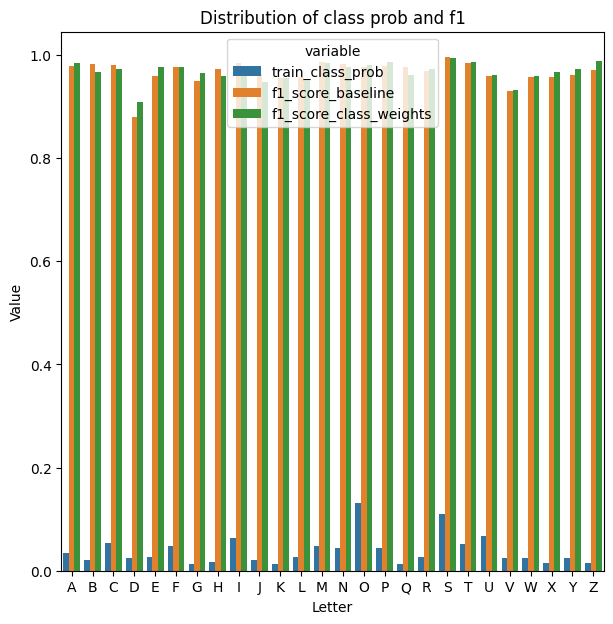

In [46]:
plot_distributions(report, 'f1_score_baseline', 'f1_score_class_weights')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x700 with 0 Axes>

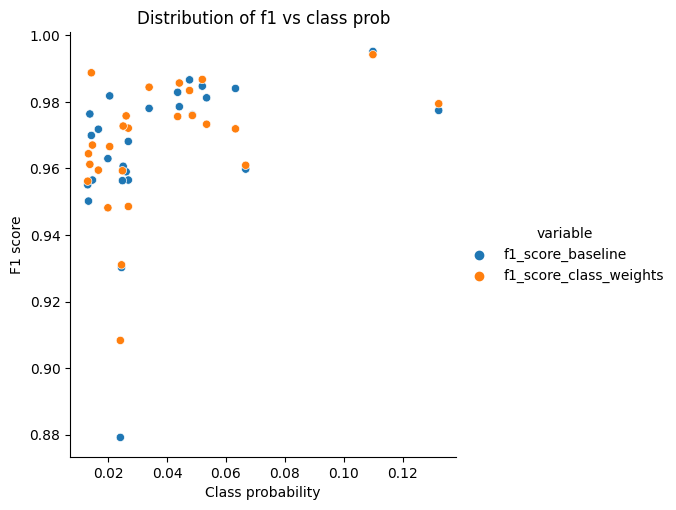

In [47]:
plot_f1_vs_class_prob(report, 'f1_score_baseline', 'f1_score_class_weights')

### Next version is to try oversampling the training set

Only some classes will be oversampled (oversampling all classes to the highest count takes too much time to train)

In [48]:
upper_quantile = int(train_class_count.quantile(q=0.75))

In [49]:
upper_quantile

7309

In [50]:
oversample_count = {i: max(upper_quantile, train_class_count[clazz]) for i, clazz in enumerate(CLASS_LABELS) }

In [51]:
oversample_count

{0: 7309,
 1: 7309,
 2: 8075,
 3: 7309,
 4: 7309,
 5: 7345,
 6: 7309,
 7: 7309,
 8: 9557,
 9: 7309,
 10: 7309,
 11: 7309,
 12: 7309,
 13: 7309,
 14: 19986,
 15: 7309,
 16: 7309,
 17: 7309,
 18: 16611,
 19: 7856,
 20: 10081,
 21: 7309,
 22: 7309,
 23: 7309,
 24: 7309,
 25: 7309}

In [52]:
from imblearn.over_sampling import RandomOverSampler

batch_size = 32
max_epochs = 30
n_classes=len(CLASS_LABELS)

image_transform = ImgTransform(image_transform, color_channel=True)
reshape_transform = Reshape(shape=(1, *IMG_SIZE))

train_rand_balanced_dataset = HandwritingsBalancedDataset(RandomOverSampler(sampling_strategy=oversample_count, random_state=42), X_file_path=DATA_DIR / 'X_train.npy', y_file_path=DATA_DIR / 'y_train.npy',
                                            data_transform=normalize, sample_transform=image_transform)

train_rand_balanced_loader = DataLoader(train_rand_balanced_dataset, num_workers=4,
                         batch_size=batch_size, shuffle=True)

In [53]:
conv_layers = [CustomConv2d(1, 32, 3, pad=1), CustomConv2d(32, 64, 3, pad=1),
               CustomConv2d(64, 128, 3, pad=1)]

n_conv_output = 28 * 28 * 128

linear_layers = [nn.Linear(n_conv_output, 1024), nn.Linear(1024, 512), nn.Linear(512, n_classes)]

cnn_checkpoint_dir = WRITING_DIR / 'cnn_3_conv_3_rand_balanced'

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=cnn_checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}',
                                      monitor='val_loss')

early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

cnn = DeepCNN(conv_layers, linear_layers)

trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=cnn_checkpoint_dir, callbacks=[checkpoint_callback, early_stopping],
                     fast_dev_run=True)
trainer.fit(cnn, train_rand_balanced_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /kaggle/working/cnn_3_conv_3_rand_balanced/best_results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [54]:
os.listdir(cnn_checkpoint_dir / 'best_results')

['epoch=1-val_loss=0.11-train_loss=0.09.ckpt',
 'epoch=1-val_loss=0.12-train_loss=0.09.ckpt']

In [55]:
cnn_checkpoint_dir = WRITING_DIR / 'cnn_3_conv_3_rand_balanced'

cnn = DeepCNN.load_from_checkpoint(cnn_checkpoint_dir / 'best_results/epoch=1-val_loss=0.11-train_loss=0.09.ckpt', convolutional_layers=conv_layers,
                                   linear_layers=linear_layers)
trainer = pl.Trainer()
predictions = trainer.predict(cnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       320
           1       0.97      0.99      0.98       194
           2       0.98      0.97      0.98       505
           3       0.92      0.92      0.92       228
           4       0.99      0.98      0.98       247
           5       0.99      0.97      0.98       459
           6       0.96      0.98      0.97       126
           7       0.97      0.98      0.97       158
           8       0.99      0.97      0.98       597
           9       0.95      0.96      0.95       188
          10       0.94      0.96      0.95       123
          11       0.94      0.97      0.95       254
          12       0.97      0.99      0.98       450
          13       0.98      0.96      0.97       412
          14       0.98      0.98      0.98      1249
          15       0.96      1.00      0.98       417
          16       0.99      0.98      0.98       130
          17       0.97    

In [56]:
clf_report_cnn_rand_balanced = get_classification_report(subtest_labels, torch.cat(predictions).numpy())

In [57]:
clf_report_cnn_rand_balanced['f1_score'].min()

0.9190371991247264

Test score: 0.90897

In [58]:
save_submission(cnn, 'cnn_rand_tv_balanced_model.csv', image_transform)

Predicting: 0it [00:00, ?it/s]

In [59]:
report['f1_score_rand_balanced'] = clf_report_cnn_rand_balanced['f1_score']

In [60]:
report.sort_values(by=['support'])

,f1_score_baseline,support,train_class_prob,f1_score_class_weights,f1_score_rand_balanced
K,0.955102,123,0.013058,0.956175,0.947791
G,0.950192,126,0.013323,0.964427,0.968504
Q,0.976378,130,0.013786,0.961240,0.984496
Z,0.969925,135,0.014296,0.988764,0.969466
X,0.956522,139,0.014666,0.967033,0.956835
H,0.971787,158,0.016684,0.959502,0.974843
J,0.962963,188,0.019912,0.948187,0.954907
B,0.981818,194,0.020520,0.966581,0.979592
D,0.879167,228,0.024146,0.908316,0.919037
V,0.930233,232,0.024543,0.931034,0.920705


In [61]:
report['f1_score_rand_balanced'].min()

0.9190371991247264

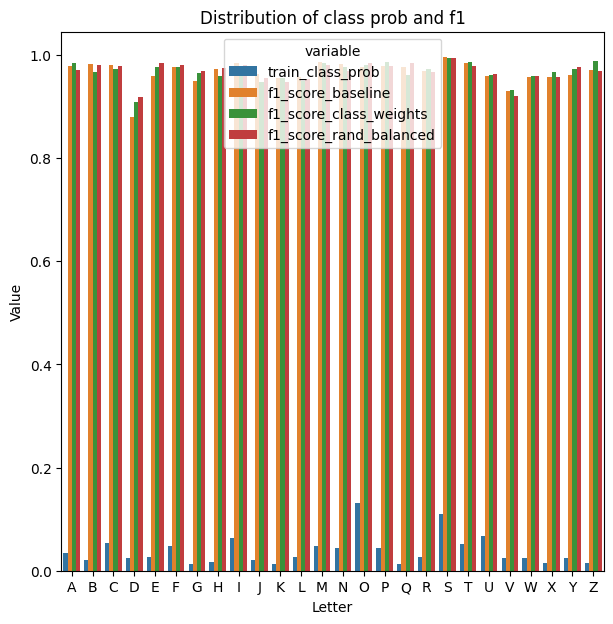

In [62]:
plot_distributions(report, 'f1_score_baseline', 'f1_score_class_weights', 'f1_score_rand_balanced')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x700 with 0 Axes>

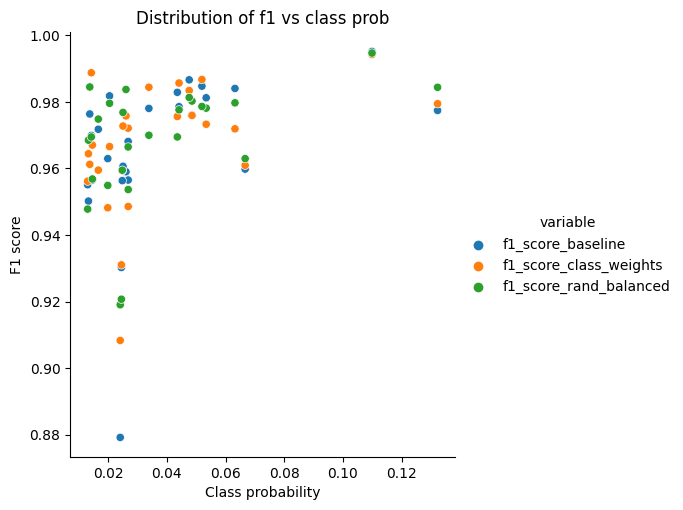

In [63]:
plot_f1_vs_class_prob(report, 'f1_score_baseline', 'f1_score_class_weights', 'f1_score_rand_balanced')

In [64]:
torch.save(cnn.state_dict(), f'cnn_3_conv_3_rand_balanced_{datetime.today().strftime("%d-%m-%Y %M_%H_%S")}')

### Increase network architecture

In [67]:
batch_size = 32
max_epochs = 35
n_classes=len(CLASS_LABELS)

dropout_prob = 0.5

conv_layers = [CustomConv2d(1, 32, 3, pad=1, drop=dropout_prob), CustomConv2d(32, 64, 3, pad=1, drop=dropout_prob), CustomConv2d(64, 64, 3, pad=1, drop=dropout_prob),
               CustomConv2d(64, 128, 3, pad=1, drop=dropout_prob)]

n_conv_output = 28 * 28 * 128

linear_layers = [nn.Linear(n_conv_output, 1024), nn.Dropout(p=dropout_prob), nn.Linear(1024, 512), nn.Linear(512, n_classes)]

cnn_checkpoint_dir = WRITING_DIR / 'cnn_4_conv_3_w_dropout'

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=cnn_checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}',
                                      monitor='val_loss')

early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

cnn = DeepCNN(conv_layers, linear_layers, class_weights=class_weights)

trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=cnn_checkpoint_dir, callbacks=[checkpoint_callback, early_stopping],
                     fast_dev_run=True)
trainer.fit(cnn, train_loader, val_loader)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [68]:
os.listdir(cnn_checkpoint_dir / 'best_results')

['epoch=10-val_loss=0.13-train_loss=0.25.ckpt']

In [69]:
cnn_checkpoint_dir = WRITING_DIR / 'cnn_4_conv_3_w_dropout'
cnn = DeepCNN.load_from_checkpoint(cnn_checkpoint_dir / 'best_results/epoch=10-val_loss=0.13-train_loss=0.25.ckpt', convolutional_layers=conv_layers,
                                   linear_layers=linear_layers)
trainer = pl.Trainer()
predictions = trainer.predict(cnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       320
           1       0.97      0.98      0.98       194
           2       0.99      0.98      0.98       505
           3       0.87      0.91      0.89       228
           4       0.96      0.98      0.97       247
           5       0.97      0.98      0.97       459
           6       0.97      0.94      0.96       126
           7       0.94      0.97      0.96       158
           8       0.96      0.98      0.97       597
           9       0.94      0.96      0.95       188
          10       0.98      0.96      0.97       123
          11       0.98      0.96      0.97       254
          12       0.98      0.99      0.99       450
          13       0.98      0.97      0.97       412
          14       0.98      0.98      0.98      1249
          15       0.99      0.99      0.99       417
          16       0.91      0.98      0.95       130
          17       0.98    

In [76]:
torch.save(cnn, f'cnn_4_conv_3_w_dropout_{datetime.today().strftime("%d-%m-%Y %M_%H_%S")}')

In [70]:
clf_report_cnn_dropout = get_classification_report(subtest_labels, torch.cat(predictions).numpy())

In [71]:
report['f1_score_w_dropout'] = clf_report_cnn_dropout['f1_score']

In [72]:
report['f1_score_w_dropout'].min()

0.8865096359743041

In [73]:
print_summary(report, 'f1_score_w_dropout')

Mean f1 score [f1_score_w_dropout] = 0.965
Mean train class prob = 0.038
Classes with f1 score BELOW mean
    f1_score_w_dropout  train_class_prob
D            0.886510          0.024146
G            0.955823          0.013323
H            0.956250          0.016684
J            0.950131          0.019912
Q            0.948148          0.013786
U            0.950846          0.066688
V            0.915254          0.024543
W            0.955975          0.024847
X            0.964286          0.014666
Y            0.955603          0.025098
Classes with probability BELOW mean
    f1_score_w_dropout  train_class_prob
A            0.987500          0.033910
B            0.976864          0.020520
D            0.886510          0.024146
E            0.968000          0.026110
G            0.955823          0.013323
H            0.956250          0.016684
J            0.950131          0.019912
K            0.967213          0.013058
L            0.970179          0.026865
Q            0.9

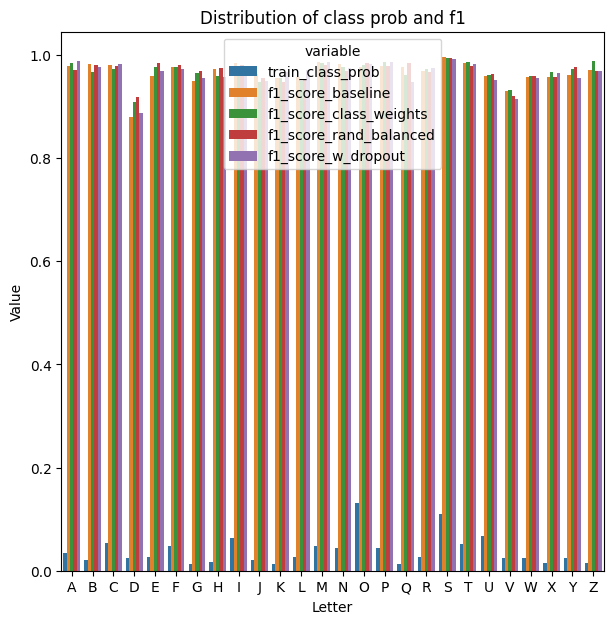

In [74]:
plot_distributions(report, 'f1_score_baseline', 'f1_score_class_weights', 'f1_score_rand_balanced', 'f1_score_w_dropout')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 700x700 with 0 Axes>

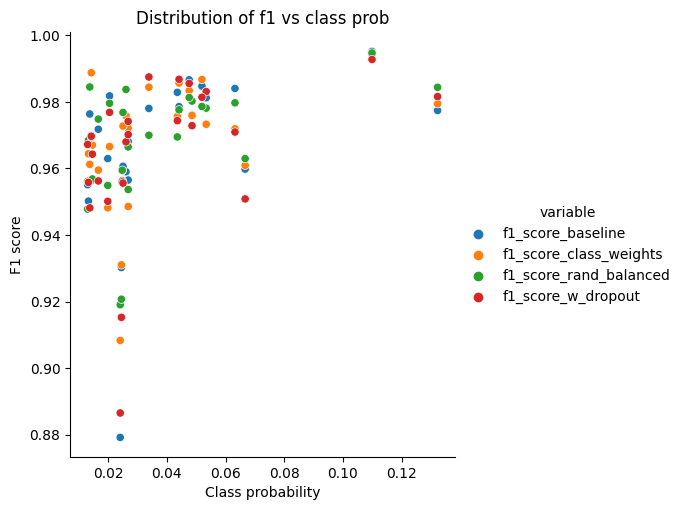

In [75]:
plot_f1_vs_class_prob(report, 'f1_score_baseline', 'f1_score_class_weights', 'f1_score_rand_balanced', 'f1_score_w_dropout')

In [89]:
!zip -r "cnn_models_kaggle.zip" "/kaggle/working/cnn_3_conv_3_rand_balanced_05-11-2023 03_14_49" "/kaggle/working/cnn_3_conv_3_lin_class_weights_05-11-2023 59_13_09" "/kaggle/working/cnn_4_conv_3_w_dropout_05-11-2023 05_14_45" "/kaggle/working/cnn_rand_balanced_model" "/kaggle/working/cnn_model_05-11-2023 14_12_05"

  adding: kaggle/working/cnn_3_conv_3_rand_balanced_05-11-2023 03_14_49 (deflated 8%)
  adding: kaggle/working/cnn_3_conv_3_lin_class_weights_05-11-2023 59_13_09 (deflated 8%)
  adding: kaggle/working/cnn_4_conv_3_w_dropout_05-11-2023 05_14_45 (deflated 7%)
  adding: kaggle/working/cnn_rand_balanced_model (deflated 64%)
  adding: kaggle/working/cnn_model_05-11-2023 14_12_05 (deflated 8%)


In [90]:
!zip -r "cnn_models_logs_kaggle.zip" "/kaggle/working/cnn_3_conv_3_lin" "/kaggle/working/cnn_3_conv_3_lin_class_weights" "/kaggle/working/cnn_3_conv_3_rand_balanced" "/kaggle/working/cnn_4_conv_3_w_dropout"

  adding: kaggle/working/cnn_3_conv_3_lin/ (stored 0%)
  adding: kaggle/working/cnn_3_conv_3_lin/best_results/ (stored 0%)
  adding: kaggle/working/cnn_3_conv_3_lin/best_results/epoch=2-val_loss=0.11-train_loss=0.08.ckpt (deflated 29%)
  adding: kaggle/working/cnn_3_conv_3_lin/lightning_logs/ (stored 0%)
  adding: kaggle/working/cnn_3_conv_3_lin/lightning_logs/version_0/ (stored 0%)
  adding: kaggle/working/cnn_3_conv_3_lin/lightning_logs/version_0/hparams.yaml (stored 0%)
  adding: kaggle/working/cnn_3_conv_3_lin/lightning_logs/version_0/events.out.tfevents.1699172070.6bb1bc885100.32.9 (deflated 70%)
  adding: kaggle/working/cnn_3_conv_3_lin_class_weights/ (stored 0%)
  adding: kaggle/working/cnn_3_conv_3_lin_class_weights/best_results/ (stored 0%)
  adding: kaggle/working/cnn_3_conv_3_lin_class_weights/best_results/epoch=4-val_loss=0.12-train_loss=0.08.ckpt (deflated 33%)
  adding: kaggle/working/cnn_3_conv_3_lin_class_weights/cnn_model_weights_05-11-2023 59:08:06 (deflated 8%)
  add